In [5]:
!nvidia-smi

Thu Jun 27 18:19:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              3W /   84W |      34MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!python --version

Python 3.11.9


In [7]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.45  Python-3.11.9 torch-2.3.1+cpu CPU (12th Gen Intel Core(TM) i5-12500H)
Setup complete  (16 CPUs, 15.6 GB RAM, 305.1/953.9 GB disk)


In [8]:
from ultralytics import YOLO
import cv2
from PIL import Image as PILImage
from IPython.display import display, Image

In [9]:
model = YOLO(f'yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 d:\Coding\Python_Programming\ANPR\dog.jpeg: 640x384 1 person, 1 car, 1 dog, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)


In [10]:
model = YOLO(f'best.pt')
image = PILImage.open("sample.png")
results = model.predict(source=image, conf=0.25)
# results = model.predict(source='test.jpg', conf=0.25 , save=True)


0: 384x640 4 License_Plates, 132.5ms
Speed: 2.0ms preprocess, 132.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
results[0].boxes.data.tolist()

[[500.96356201171875,
  886.4089965820312,
  597.71484375,
  923.9126586914062,
  0.626331090927124,
  0.0],
 [1211.5064697265625,
  778.73583984375,
  1288.612548828125,
  816.2449951171875,
  0.6045674085617065,
  0.0],
 [51.32539367675781,
  398.26995849609375,
  95.39958953857422,
  417.6294250488281,
  0.2827376127243042,
  0.0],
 [935.6991577148438,
  1008.2431640625,
  973.7334594726562,
  1046.8626708984375,
  0.2687482237815857,
  0.0]]

In [12]:
x1, y1, x2, y2, score, class_id = results[0].boxes.data.tolist()[0]
[x1,y1,x2,y2,score,class_id]

[500.96356201171875,
 886.4089965820312,
 597.71484375,
 923.9126586914062,
 0.626331090927124,
 0.0]

In [13]:
# !pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

In [14]:

from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model_scale = "4" #@param ["2", "4", "8"] {allow-input: false}

model = RealESRGAN(device, scale=int(model_scale))
model.load_weights(f'RealESRGAN_x4.pth')

device: cpu


In [31]:
#@title Upload and upscale images or .tar archives
IMAGE_FORMATS = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')
def process_input(filename,bbox):
    image = Image.open(filename).convert('RGB').crop(bbox)
    sr_image = model.predict(np.array(image))
    sr_image.save("output.png")
    threshold_value = 120
    # Create a binary image with inverse thresholding
    binary_image = sr_image.convert("L").point(lambda p: 255 if p < threshold_value else 0)
    binary_image.save("output_binary.png")
    print(f'Finished! Image saved')
process_input('sample.png',[x1, y1, x2, y2])

Finished! Image saved


In [44]:

import numpy as np
# Load an image from file
from PIL import Image as PILImage
image = PILImage.open("sample.png")

bbox = [x1, y1, x2, y2]
# Crop the image using the bounding box coordinates
cropped_image = image.crop(bbox)

# Convert the cropped image to grayscale
gray_image = cropped_image.convert("L")

# Apply a threshold to the grayscale image
threshold_value = 120

# Create a binary image with inverse thresholding
binary_image = gray_image.point(lambda p: 255 if p < threshold_value else 0)

# Display the binary image
binary_image.show()
# binary_image = np.array(binary_image)
# Optionally, save the cropped image
# cropped_image.save('cropped_image.jpg')


In [34]:
import easyocr

# Initialize the OCR reader
reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext("output_binary.png")

for (bbox, text, prob) in result:
    text = ''.join(list(map(lambda x: x.strip(), text.split())))
    # if len(text) < 9 or len(text) > 10:
    #     continue
    print(f'Text: {text}, Probability: {prob}')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Text: NAI3MrU, Probability: 0.14497648984171513


In [ ]:
# Initialize the OCR reader
import string

reader = easyocr.Reader(["en"], gpu=True)

# Mapping dictionaries for character conversion
dict_char_to_int = {"O": "0", "I": "1", "J": "3", "A": "4", "G": "6", "S": "5"}

dict_int_to_char = {"0": "O", "1": "I", "3": "J", "4": "A", "6": "G", "5": "S"}


def license_complies_format(text):
    """
    Check if the license plate text complies with the required format.

    Args:
        text (str): License plate text.

    Returns:
        bool: True if the license plate complies with the format, False otherwise.
    """
    # Check the length of the license plate text
    length = len(text)
    if length != 9 and length != 10:
        print("Invalid length" , length)
        return False

    # CCNNCONNNN format
    if length == 10:
        if (
            (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys())
            and (
                text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()
            )
            and (
                text[2] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[2] in dict_char_to_int.keys()
            )
            and (
                text[3] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()
            )
            and (
                text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()
            )
            and (
                text[6] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[7] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[8] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[9] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
        ):
            return True
    elif length == 9:
        if (
            (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys())
            and (
                text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()
            )
            and (
                text[2] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[2] in dict_char_to_int.keys()
            )
            and (
                text[3] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()
            )
            and (
                text[5] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[6] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[7] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
            and (
                text[8] in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
                or text[3] in dict_char_to_int.keys()
            )
        ):
            return True
    else:
        return False


def format_license(text):
    """
    Format the license plate text by converting characters using the mapping dictionaries.

    Args:
        text (str): License plate text.

    Returns:
        str: Formatted license plate text.
    """
    # CCNNCONNNN
    license_plate_ = ""

    # Check the length of the license plate text
    if len(text) == 10:
        # Mapping for a 10-character license plate
        mapping = {
            0: dict_int_to_char,
            1: dict_int_to_char,
            2: dict_char_to_int,
            3: dict_char_to_int,
            4: dict_int_to_char,
            5: dict_int_to_char,
            6: dict_char_to_int,
            7: dict_char_to_int,
            8: dict_char_to_int,
            9: dict_char_to_int,
        }
    else:
        # Mapping for a 9-character license plate
        mapping = {
            0: dict_int_to_char,
            1: dict_int_to_char,
            2: dict_char_to_int,
            3: dict_char_to_int,
            4: dict_int_to_char,
            5: dict_char_to_int,
            6: dict_char_to_int,
            7: dict_char_to_int,
            8: dict_char_to_int,
        }

    # Iterate over the mapping keys
    for j in mapping.keys():
        # Check if the character at index j in the text is in the mapping dictionary
        if text[j] in mapping[j].keys():
            # If it is, append the mapped character to the license_plate_ string
            license_plate_ += mapping[j][text[j]]
        else:
            # If it is not, append the original character to the license_plate_ string
            license_plate_ += text[j]

    return license_plate_


def read_license_plate(license_plate_crop):
    """
    Read the license plate text from the given cropped image.

    Args:
        license_plate_crop (PIL.Image.Image): Cropped image containing the license plate.

    Returns:
        tuple: Tuple containing the formatted license plate text and its confidence score.
               If the license plate text cannot be read, None is returned for both elements of the tuple.
    """

    # Perform text detection on the license plate crop
    detections = reader.readtext(license_plate_crop)

    for detection in detections:
        bbox, text, score = detection

        # Preprocess the detected text
        text = text.upper().replace(" ", "")

        # Print the detected text and its confidence score
        print(text, score)

        # Check if the license plate text complies with the expected format
        if license_complies_format(text):
            # Format the license plate text and return it along with the confidence score
            return format_license(text), score

    # If no valid license plate text is found, return None for both elements of the tuple
    return None, None


read_license_plate(binary_image)

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def draw_border(img, car_bbox, license_plate_bbox, license_plate_text,license_plate_score, thickness=10, line_length_x=50, line_length_y=50):
    draw = ImageDraw.Draw(img)
    car_color = "green"
    license_plate_color = "red"
    x1, y1, x2, y2 = car_bbox
    lp_x1, lp_y1, lp_x2, lp_y2 = map(int, license_plate_bbox)
        
    ## Draw the border for car bounding box
    # Top-left
    draw.line([(x1, y1), (x1, y1 + line_length_y)], fill=car_color, width=thickness)
    draw.line([(x1, y1), (x1 + line_length_x, y1)], fill=car_color, width=thickness)

    # Bottom-left
    draw.line([(x1, y2), (x1, y2 - line_length_y)], fill=car_color, width=thickness)
    draw.line([(x1, y2), (x1 + line_length_x, y2)], fill=car_color, width=thickness)

    # Top-right
    draw.line([(x2, y1), (x2 - line_length_x, y1)], fill=car_color, width=thickness)
    draw.line([(x2, y1), (x2, y1 + line_length_y)], fill=car_color, width=thickness)

    # Bottom-right
    draw.line([(x2, y2), (x2, y2 - line_length_y)], fill=car_color, width=thickness)
    draw.line([(x2, y2), (x2 - line_length_x, y2)], fill=car_color, width=thickness)
    
    # Draw the license plate bounding box
    draw.rectangle(license_plate_bbox, outline=license_plate_color, width=thickness//2)
    
    font = ImageFont.load_default(size=16)
    score_text = f"Score: {license_plate_score:.2f}"
    draw.text((lp_x1, lp_y2), license_plate_text, fill ="white", font = font, align ="right") 
    draw.text((lp_x2, lp_y2), score_text, fill ="white", font = font, align ="right") 
    
    return img

# Example usage
res = {
    'car': {'bbox': [375.3855895996094, 684.0321655273438, 718.805419921875, 990.9774169921875]}, 
    'license_plate': {
        'bbox': [500.96356201171875, 886.4089965820312, 597.71484375, 923.9126586914062], 
        'text': 'NA13NRU', 
        'bbox_score': 0.6263312101364136, 
        'text_score': 0.8679459956177277
    }
}
car_bbox = res['car']['bbox']
license_plate_bbox = res['license_plate']['bbox']
license_plate_text = res['license_plate']['text']
license_plate_score = res['license_plate']['text_score']
image = Image.open('sample.png')
image = draw_border(image, car_bbox, license_plate_bbox, license_plate_text, license_plate_score)
image.crop(car_bbox).show()
# image.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage

def draw_border(img, car_bbox, license_plate_bbox, license_plate_text, license_plate_score, thickness=10, line_length=50):
    car_color = (0, 255, 0)  # Green color in BGR format
    license_plate_color = (0, 0, 255)  # Red color in BGR format

    x1, y1, x2, y2 = map(int, car_bbox)
    lp_x1, lp_y1, lp_x2, lp_y2 = map(int, license_plate_bbox)

    # Draw the border for car bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), car_color, thickness)

    # Draw lines extending from corners
    cv2.line(img, (x1, y1), (x1 + line_length, y1), car_color, thickness)
    cv2.line(img, (x1, y1), (x1, y1 + line_length), car_color, thickness)

    cv2.line(img, (x2, y1), (x2 - line_length, y1), car_color, thickness)
    cv2.line(img, (x2, y1), (x2, y1 + line_length), car_color, thickness)

    cv2.line(img, (x1, y2), (x1 + line_length, y2), car_color, thickness)
    cv2.line(img, (x1, y2), (x1, y2 - line_length), car_color, thickness)

    cv2.line(img, (x2, y2), (x2 - line_length, y2), car_color, thickness)
    cv2.line(img, (x2, y2), (x2, y2 - line_length), car_color, thickness)

    


    # Draw the license plate bounding box
    cv2.rectangle(img, (lp_x1, lp_y1), (lp_x2, lp_y2), license_plate_color, 2)
    
    # For the text background
    # Finds space required by the text so that we can put a background with that amount of width.
    (w, h), _ = cv2.getTextSize(
           license_plate_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

    # # Add text for license plate text and score
    cv2.rectangle(img, (lp_x1, lp_y1 - 20), (lp_x1 + w, lp_y1), license_plate_color, -1)
    cv2.putText(img,license_plate_text, (lp_x1, lp_y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255,255,255], 1)
    
    score_text = f"Score: {license_plate_score:.2f}"
    (w, h), _ = cv2.getTextSize(
           score_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    cv2.rectangle(img, (lp_x1, lp_y2 + 20), (lp_x1 + w, lp_y2), license_plate_color, -1)
    cv2.putText(img,score_text, (lp_x1, lp_y2 + 17),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, [255,255,255], 1)

    return img

# Example usage
res = {
    'car': {'bbox': [375, 684, 718, 990]}, 
    'license_plate': {
        'bbox': [500, 886, 597, 923], 
        'text': 'NA13NRU', 
        'bbox_score': 0.6263312101364136, 
        'text_score': 0.8679459956177277
    }
}
car_bbox = res['car']['bbox']
license_plate_bbox = res['license_plate']['bbox']
license_plate_text = res['license_plate']['text']
license_plate_score = res['license_plate']['text_score']
image = cv2.imread('sample.png')

# Convert image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_with_boxes = draw_border(image_rgb, car_bbox, license_plate_bbox, license_plate_text, license_plate_score)

# Convert image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_with_boxes = draw_border(image_rgb, car_bbox, license_plate_bbox, license_plate_text, license_plate_score)

# Convert OpenCV image to PIL image
pil_image = PILImage.fromarray(image_with_boxes)

# Display the image using PIL (opens in default viewer)
pil_image.crop(car_bbox).show()


In [4]:
# !pip install peewee

  Using cached peewee-3.17.5.tar.gz (3.0 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.5-py3-none-any.whl size=138680 sha256=d3618369ce0680580efaf1dbebbb27ba2db8e89664aa849dab3948f19809ae42
  Stored in directory: c:\users\harsh\appdata\local\pip\cache\wheels\d2\cb\9c\c300d7bf782e07f1658c306743d5e30af7e4834001e4064a96
Successfully built peewee



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from peewee import *

db = SqliteDatabase('vehicles.sqlite')

class Vehicle(Model):
    number_plate = CharField()
    emission_done = BooleanField()
    
    def __str__(self): 
        return self.number_plate
    
    class Meta:
        database = db # This model uses the "people.db" database.



In [ ]:
# db.connect()
# db.create_tables([Vehicle])

In [21]:
car = Vehicle(number_plate="MH20DV2363", emission_done=True)
car.save()

1

In [4]:
# Update
car.emission_done = True
car.save()

1

In [30]:
# Get single record with condition
try:
    print(Vehicle.get(Vehicle.number_plate == "MH20DV2363"))
except Vehicle.DoesNotExist:
    print("Vehicle not found")

MH20DV2363


In [18]:
# All records
for vehicle in Vehicle.select():
    print(vehicle.number_plate, vehicle.emission_done)

 False
AC12A4519 False
AC12A4519 True


In [20]:
# Delete all records
Vehicle.delete().execute()

3

In [10]:
import os
os.chdir("../")
os.getcwd()

'/home/dev/projects/ANPR'

In [13]:
from peewee import *

db = SqliteDatabase('vehicles.sqlite')

class VehicleModel(Model):
    number_plate = CharField()
    emission_done = BooleanField()
    
    def __str__(self): 
        return self.number_plate
    
    class Meta:
        database = db # This model uses the "people.db" database.

# db.create_tables([VehicleModel])
try:
    db.connect()
    print("Connected to database")
    car = VehicleModel(number_plate="MH20EE7602", emission_done=True)
    car.save()
except Exception as e:
    print(e)

Connected to database


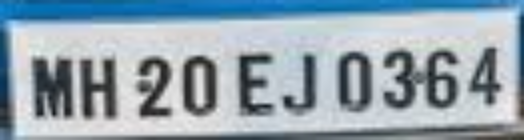

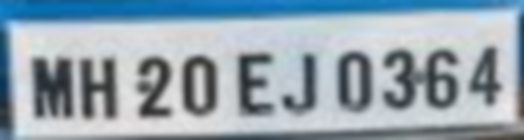

In [8]:
from PIL import Image, ImageFilter

# Open an existing image
original_image = Image.open('../detection/images/crop.png')

# Apply a blur filter to the image
blurred_image = original_image.filter(ImageFilter.GaussianBlur)

# Display the original image 
original_image.show()

# Display the blurred mage
blurred_image.show()
blurred_image.save("img.png")
